In [2]:
import pandas as pd
import re
import seaborn
from string import punctuation
from nltk.corpus import stopwords
import pymorphy2
import matplotlib.pyplot as plt
import spacy_sentence_bert
import tqdm as notebook_tqdm
from itertools import combinations
import spacy
from sentence_transformers import SentenceTransformer, util
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import datasets
import torch
from transformers import AutoTokenizer, AutoModel
import torchdata

d:\InternationalDB\IntDB\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
def print_simple_data_pipe(date_pipe: torchdata.datapipes.iter.IterDataPipe, f=lambda a: a, n=10) -> None:
  print(type(date_pipe))
  x = 0
  for sample in date_pipe:
    print(f(sample))
    if x == n:
      break
    x +=1


In [3]:
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
sentence_vectorizer = AutoModel.from_pretrained("ai-forever/sbert_large_nlu_ru")


In [4]:
data = pd.read_csv('./DATA/Hack/train_dataset_train.csv', sep=";")
data.head()

,Исполнитель,Группа тем,Текст инцидента,Тема
0,Лысьвенский городской округ,Благоустройство,"'Добрый день. Сегодня, 20.08.22, моя мать шла ...",★ Ямы во дворах
1,Министерство социального развития ПК,Социальное обслуживание и защита,"'Пермь г, +79194692145. В Перми с ноября 2021 ...",Оказание гос. соц. помощи
2,Министерство социального развития ПК,Социальное обслуживание и защита,'Добрый день ! Скажите пожалуйста если подовал...,Дети и многодетные семьи
3,Город Пермь,Общественный транспорт,'Каждая из них не о чем. Люди на остановках хо...,Содержание остановок
4,Министерство здравоохранения,Здравоохранение/Медицина,'В Березниках у сына привитого откоронавируса ...,Технические проблемы с записью на прием к врачу


In [5]:
data_p = data.copy(deep=True)
data_p['Текст инцидента'] = data_p['Текст инцидента'].apply(lambda a: tokenizer([a], padding=True, truncation=True, max_length=500, return_tensors='pt')['input_ids'])

# Check

In [6]:
sentences = data['Текст инцидента'][0:3]

In [7]:
encoded_input = tokenizer(sentences.to_list(), padding=True, truncation=True, max_length=24, return_tensors='pt')


In [8]:
encoded_input

{'input_ids': tensor([[  101,   245, 48311,   378,  1336,   126,  1806,   121,   830,   126,
          8535,   126,  2473,   121,  4137,  4503,  7030,   654,  3907, 31238,
           377,  1289, 30432,   102],
        [  101,   245, 36020,   394,   122,   121,   250, 11465, 15058, 52399,
         60011, 15167,   438,   126,   113, 36020,   378,   110,  2819, 57752,
           878,   672,  4209,   102],
        [  101,   245, 48311,   378,  1336,   177, 19735, 10511, 28687,   715,
          1081,  1258,  1524,   660, 37193,   110,   168,   708,   182,   149,
          2988,   121,  1040,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 

In [9]:
encoded_input['input_ids'].shape

torch.Size([3, 24])

In [10]:
with torch.no_grad():
    model_output = sentence_vectorizer(**encoded_input)

In [36]:
model_output[0].shape

torch.Size([3, 24, 1024])

# Analize text length

In [11]:
len_texts = data_p['Текст инцидента'].apply(lambda a: a.shape[1])

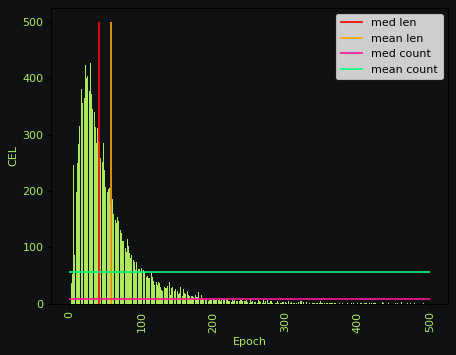

In [13]:
fig = plt.figure(num=None, dpi=80, facecolor='#101113', edgecolor='#ABE85D')
plt.axes().set_facecolor('#101113')
plt.xticks(color="#ABE85D")
plt.yticks(color="#ABE85D")
plt.ylabel('CEL', color="#ABE85D")
plt.xlabel('Epoch', color="#ABE85D")
plt.xticks(rotation = 90)
plt.vlines(len_texts.median(), ymin=0, ymax=500, colors='r', label='med len')
plt.vlines(len_texts.mean(), ymin=0, ymax=500, colors='orange', label='mean len')
plt.hlines(len_texts.value_counts().median(), xmin=0, xmax=500, colors='deeppink', label='med count')
plt.hlines(len_texts.value_counts().mean(), xmin=0, xmax=500, colors='springgreen', label='mean count')
plt.bar(len_texts.value_counts().index, len_texts.value_counts(), color='#ABE85D')
plt.legend()
plt.show()

# Преобразование даты

Уменьшим число признаков

In [7]:
theme_group_counts = data['Группа тем'].value_counts()
b = theme_group_counts[theme_group_counts > theme_group_counts.median()].index.to_list()
data_rem_c = data.loc[data['Группа тем'].apply(lambda a: a in b)]
data_rem_c.head()

,Исполнитель,Группа тем,Текст инцидента,Тема
0,Лысьвенский городской округ,Благоустройство,"'Добрый день. Сегодня, 20.08.22, моя мать шла ...",★ Ямы во дворах
1,Министерство социального развития ПК,Социальное обслуживание и защита,"'Пермь г, +79194692145. В Перми с ноября 2021 ...",Оказание гос. соц. помощи
2,Министерство социального развития ПК,Социальное обслуживание и защита,'Добрый день ! Скажите пожалуйста если подовал...,Дети и многодетные семьи
3,Город Пермь,Общественный транспорт,'Каждая из них не о чем. Люди на остановках хо...,Содержание остановок
4,Министерство здравоохранения,Здравоохранение/Медицина,'В Березниках у сына привитого откоронавируса ...,Технические проблемы с записью на прием к врачу


In [8]:
name_os, system_os = RandomUnderSampler().fit_resample(data_rem_c.loc[:, ['Текст инцидента']], data_rem_c['Группа тем'])
data_os = pd.DataFrame({'Текст инцидента': name_os['Текст инцидента'], 'Группа тем': system_os})
print("OS:", data_os.shape)
print("Prev:", data_rem_c.shape)
data_os.head()

OS: (1560, 2)
Prev: (22567, 4)


,Текст инцидента,Группа тем
10484,"'Это собака с металлистов 24 2 подъезд, её час...",Безопасность
5528,"'Сегодня на Фрунзе целая стая штук 20 бегает, ...",Безопасность
6455,'Добрый день! Некая религиозная организация об...,Безопасность
22524,"'Пермь г, +79824940415. Доброго дня!\n\n\nПрош...",Безопасность
1618,'#9вопросовчиновникам<br>А вот та самая лохмат...,Безопасность


In [24]:
theme_group_classes = {j: i for i, j in enumerate(data_os['Группа тем'].unique())}

In [26]:
X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(data_os['Текст инцидента'], data_os['Группа тем'])
X_train, X_test, y_train, y_test = train_test_split(data_os['Текст инцидента'], data_os['Группа тем'])
pd.DataFrame({'name': X_train_os, 'system': y_train_os}).to_csv('./os_dataset_train.csv', index=False)
pd.DataFrame({'name': X_test_os, 'system': y_test_os}).to_csv('./os_dataset_test.csv', index=False)


def processing(pair):
    with torch.no_grad():
        e = tokenizer(pair[0], padding=True, truncation=True, max_length=128, return_tensors='pt')
        k = sentence_vectorizer(**e)[0]
    return (k, torch.nn.functional.one_hot(torch.tensor([theme_group_classes[pair[1]]]), len(theme_group_classes))[0])

In [27]:
train_pairs = torchdata.datapipes.iter.IterableWrapper(['./os_dataset_train.csv'])
train_pairs = torchdata.datapipes.iter.FileOpener(train_pairs, mode='r', encoding='utf-8', )
train_pairs = train_pairs.parse_csv(skip_lines=1, delimiter=',')
train_pairs = train_pairs.shuffle().map(processing)
print_simple_data_pipe(train_pairs, lambda a: (a[0].shape, a[1].shape), n=1)

<class 'torch.utils.data.datapipes.iter.callable.MapperIterDataPipe'>
(torch.Size([1, 17, 1024]), torch.Size([13]))
(torch.Size([1, 11, 1024]), torch.Size([13]))


# Build Model

In [28]:
transformer_model = torch.nn.Transformer(d_model=1024, nhead=16, num_encoder_layers=12)

In [58]:
model_output[0].transpose(0, 1).shape

torch.Size([24, 3, 1024])

In [37]:
transformer_model(model_output[0].transpose(0, 1), torch.rand((1, 3, 1024))).transpose(0, 1).squeeze(1).shape

torch.Size([3, 1024])

In [101]:
class VecSeqModel(torch.nn.Module):
    def __init__(self, d_model, nhead, num_encoder_layers, d_output):
        super().__init__()
        self.transformer = torch.nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers)
        self.output_layer = torch.nn.Linear(d_model, d_output)
    
    def forward(self, x):
        y = x.transpose(0, 1).float()
        m = torch.ones(1, y.shape[1], y.shape[2]).float().to('cuda')
        # print(y.shape, m.shape)
        y = self.transformer(y, m).transpose(0, 1).squeeze(1)
        # print('l', y.shape)
        y = self.output_layer(y)
        return y

In [102]:
model = VecSeqModel(
    d_model=1024, 
    nhead=16, 
    num_encoder_layers=5, 
    d_output=13
).to('cuda')

In [103]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [104]:
er_list = []

In [105]:
epochs = 50
for epoch in range(epochs):
    print(epoch)
    for x, y in train_pairs:
        outputs = model(x.to('cuda'))
        loss_value = loss(outputs, y.view(1, -1).double().to('cuda'))
        loss_value.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()
    er_list.append(loss_value.item())
    print(f'Эпоха {epoch + 1}, Значение функции потерь: {loss_value.item()}')

0
Эпоха 1, Значение функции потерь: 2.4550023078918457
1
Эпоха 2, Значение функции потерь: 2.4064314365386963
2
Эпоха 3, Значение функции потерь: 2.6758651733398438
3
Эпоха 4, Значение функции потерь: 2.9969875812530518
4
Эпоха 5, Значение функции потерь: 2.709796190261841
5
Эпоха 6, Значение функции потерь: 2.9478578567504883
6
Эпоха 7, Значение функции потерь: 2.657487392425537
7
Эпоха 8, Значение функции потерь: 2.2277629375457764
8
Эпоха 9, Значение функции потерь: 3.0569655895233154
9
Эпоха 10, Значение функции потерь: 2.854581832885742
10
Эпоха 11, Значение функции потерь: 3.100590944290161
11
Эпоха 12, Значение функции потерь: 2.4538111686706543
12
Эпоха 13, Значение функции потерь: 2.5494165420532227
13
Эпоха 14, Значение функции потерь: 2.3423750400543213
14
Эпоха 15, Значение функции потерь: 1.5860811471939087
15
Эпоха 16, Значение функции потерь: 2.8950929641723633
16
Эпоха 17, Значение функции потерь: 2.125772714614868
17
Эпоха 18, Значение функции потерь: 2.724887847900390